In [1]:
# Importing the necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Setting start (ten years ago) and end (today) dates for data download
end_date = datetime.now()
start_date = end_date - timedelta(days=3650)

# Downloading the adjusted OHLC prices of Microsoft daily data for the past 10 years, using the yfinance API
msft = yf.download("MSFT", start = start_date, end = end_date, auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

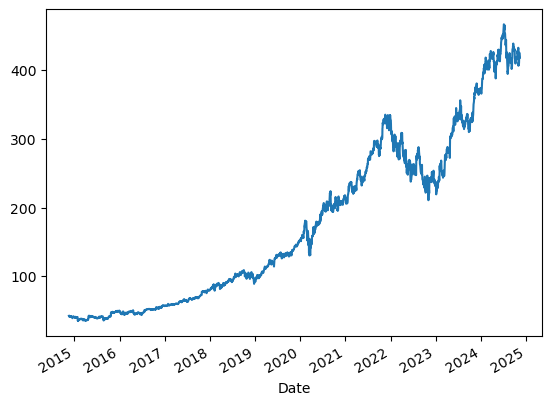

In [2]:
# This is how the close prices have been over the past year
msft["Close"].plot()

In [3]:
# Most recent close price
msft["Close"].iloc[-1]

# Earliest close price (in the downloaded data)
msft["Close"].iloc[0]

# Range = most recent - earliest price
price_range = msft["Close"].iloc[-1] - msft["Close"].iloc[0]

# Number of gaps = number of data points - 1
gaps = len(msft) - 1

# Drift value
price_drift = price_range/gaps

# Creating a column that would be populated with the prices had the stock price followed only the drift, and not the volatility
msft["Drift_Component"] = 0
msft["Drift_Component"].iloc[0] = msft["Close"].iloc[0]

for i in range(len(msft)):
    if i > 0:
        msft["Drift_Component"].iloc[i] = msft["Drift_Component"].iloc[i-1] + price_drift

In [4]:
# Calculating a column for the volatility component
msft["Volatility_Component"] = msft["Close"] - msft["Drift_Component"]

<Axes: xlabel='Date'>

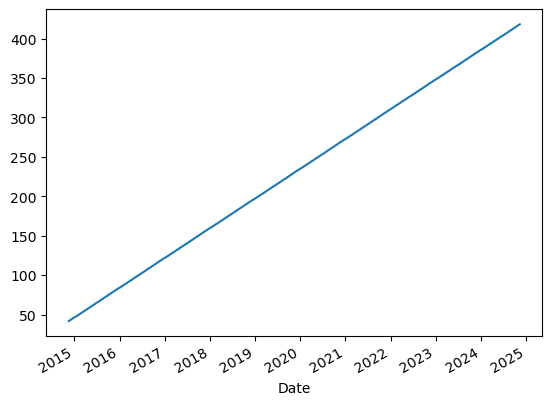

In [5]:
# This is how the drift component for the past ten years looks like
msft["Drift_Component"].plot()

<Axes: xlabel='Date'>

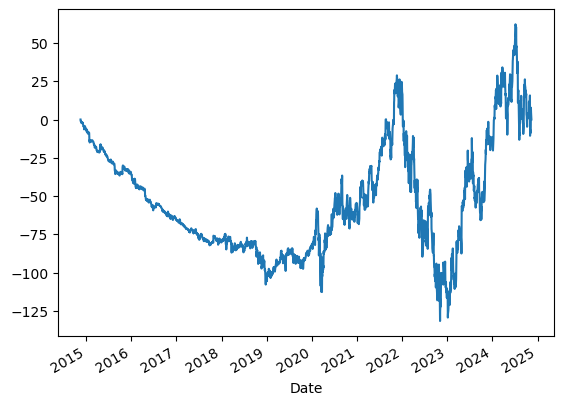

In [6]:
# This is how the volatility component for the past ten years looks like
msft["Volatility_Component"].plot()

<Axes: xlabel='Date'>

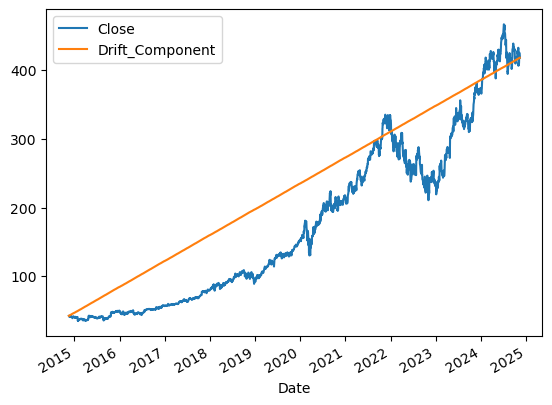

In [7]:
# Close prices and drift component superimposed
msft[["Close","Drift_Component"]].plot()

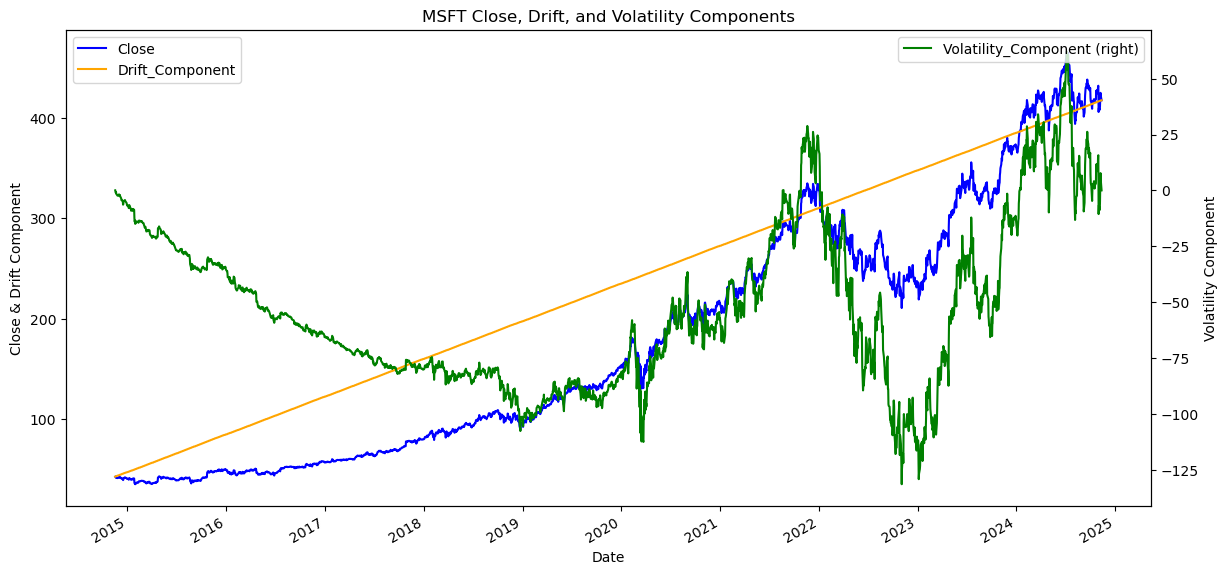

In [8]:
# Plotting Close and Drift_Component on the primary y-axis
ax = msft[["Close", "Drift_Component"]].plot(figsize=(14, 7), color=["blue", "orange"])


# Plotting Volatility_Component on the secondary y-axis
msft["Volatility_Component"].plot(ax=ax, secondary_y=True, color="green", label="Volatility_Component")


# Customizing labels and title
ax.set_ylabel("Close & Drift Component")
ax.right_ax.set_ylabel("Volatility Component")
plt.title("MSFT Close, Drift, and Volatility Components")


# Adding legends
ax.legend(loc='upper left')  # For the primary y-axis
ax.right_ax.legend(loc='upper right')  # For the secondary y-axis


# Display the plot
plt.show()


## **Weiner Process:**

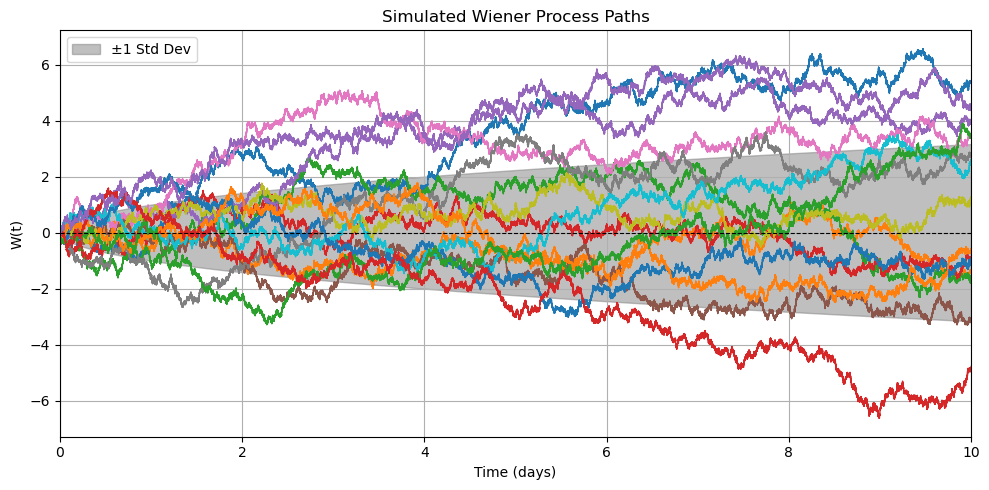

In [11]:
# Defining our parameters
M = 15  # Number of paths/simulations
T = 10  # Total days simulated
N = 864000  # Number of time steps (set such that the values change every second)
dt = T / N  # Time increment (every second)
t = np.linspace(0, T, N)  # Time vector

# Simulating Wiener process paths
np.random.seed(0)  # For reproducibility
paths = np.zeros((M, N))  # Initializing Wiener process with initial values = 0

for i in range(M):
    # Generating standard normal random variables for Wiener process increments
    increments = np.random.normal(0, np.sqrt(dt), N)
    paths[i] = np.cumsum(increments)  # Wiener process

# Calculating the mean (which is zero for a Wiener process)
mean_value = np.zeros(N)

# Plotting the Wiener process
plt.figure(figsize=(10, 5))

# Plotting Wiener process paths
plt.subplot(1, 1, 1)
plt.title('Simulated Wiener Process Paths')
plt.xlabel('Time (days)')
plt.ylabel('W(t)')
plt.xlim(0, T)
for i in range(M):
    plt.plot(t, paths[i], lw=1)
plt.fill_between(t, mean_value - np.sqrt(t), mean_value + np.sqrt(t), color='gray', alpha=0.5, label='±1 Std Dev')
plt.axhline(0, color='black', lw=0.8, ls='--')  # Mean line at zero
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Application of the Ito Rule:**

In [10]:
# Calculating the daily percent returns
msft["Daily_Returns"] = msft["Close"].pct_change()

In [11]:
# Calculating mean, standard deviation, and variance of daily percent returns
daily_mean = msft["Daily_Returns"].mean()
daily_stdev = msft["Daily_Returns"].std()
daily_var = daily_stdev**2
print("The mean of the daily percent returns = " + str(np.round(daily_mean,5)))
print("The standard deviation of the daily percent returns = " + str(np.round(daily_stdev,5)))
print("The variance of the daily percent returns = " + str(np.round(daily_var,5)))

The mean of the daily percent returns = 0.00106
The standard deviation of the daily percent returns = 0.01711
The variance of the daily percent returns = 0.00029


In [12]:
# Calculating the daily compounded returns
daily_compounded_mean = (((msft["Close"][-1]/msft["Close"][0])**(1/len(msft)))-1)
print("Daily compounded returns = " + str(np.round(daily_compounded_mean,8)))

Daily compounded returns = 0.00091206


In [13]:
# Calculating the correct daily percent returns
corrected_mean = (daily_mean - (daily_stdev**2)/2)
print("Corrected daily percent returns = " + str(np.round(corrected_mean,8)))

Corrected daily percent returns = 0.00091229


In [14]:
# Suppose we seek to predict the range within which the price of Microsoft is likely to lie after 42 trading days (2 calendar months) from now

# Calculating the convexity corrected drift (mean), variance, and standard deviation for 42 trading days
mean_42 = (daily_mean - (daily_stdev**2)/2 ) * 42
var_42 = daily_var * 42
stdev_42 = np.sqrt(var_42)
print("Corrected drift for 42 days = " + str(np.round(mean_42,8)))
print("Variance for 42 days = " + str(np.round(var_42,8)))
print("Standard deviation for 42 days = " + str(np.round(stdev_42,8)))

Corrected drift for 42 days = 0.03831631
Variance for 42 days = 0.01229602
Standard deviation for 42 days = 0.11088744


In [15]:
# Calculating the likely returns of Microsoft after 42 trading days

# Lower and upper ranges of Microsoft returns after 42 days, with 95% likelihood
lower_return_42 = mean_42 - 2 * stdev_42
upper_return_42 = mean_42 + 2 * stdev_42

# Lower and upper ranges of Microsoft prices after 42 days, with 95% likelihood
lower_price_42 = msft["Close"][-1] * np.exp(lower_return_42)
upper_price_42 = msft["Close"][-1] * np.exp(upper_return_42)

print("Price below which the stock isn't likely to trade with a 95% probability after 42 days = " + str(np.round(lower_price_42,2)))
print("Price above which the stock isn't likely to trade with a 95% probability after 42 days = " + str(np.round(upper_price_42,2)))

Price below which the stock isn't likely to trade with a 95% probability after 42 days = 347.95
Price above which the stock isn't likely to trade with a 95% probability after 42 days = 542.18


In [16]:
# Downloading the option chain of Microsoft with expiry on the 20th of December 2024, two months from now
msft_optc = yf.Ticker("MSFT").option_chain('2024-12-20')

In [17]:
# Selecting the put with a strike of $345, and the call with strike of $545

put_345 = msft_optc.puts[msft_optc.puts['strike'] == 345]
call_545 = msft_optc.calls[msft_optc.calls['strike'] == 545]

print("Put with strike 345:\n", put_345)
print("\nCall with strike 545:\n", call_545)


Put with strike 345:
          contractSymbol             lastTradeDate  strike  lastPrice  bid  \
44  MSFT241220P00345000 2024-11-11 20:55:08+00:00   345.0       0.31  0.0   

    ask  change  percentChange  volume  openInterest  impliedVolatility  \
44  0.0     0.0            0.0     6.0          1505           0.125009   

    inTheMoney contractSize currency  
44       False      REGULAR      USD  

Call with strike 545:
          contractSymbol             lastTradeDate  strike  lastPrice  bid  \
84  MSFT241220C00545000 2024-11-11 14:37:12+00:00   545.0       0.04  0.0   

    ask  change  percentChange  volume  openInterest  impliedVolatility  \
84  0.0     0.0            0.0       1           357           0.125009   

    inTheMoney contractSize currency  
84       False      REGULAR      USD  


## **Markdowns:**

$\frac{dz}{dx}$

$\frac{dz}{dx}$ = $3$

$\frac{dy}{dz}$ = $cos(x)$

$\frac{dy}{dx}$ = $\frac{dy}{dz} * \frac{dz}{dx}$

$\frac{dy}{dx}$ = $3cos(x)$

$dS_t = \mu S_t dt + \sigma S_t dW_t$

$df(S_t) = f’(S_t)dS_t + ½(f’’(S_t)d[S, S]_t)	$

$\lim_{\Delta t \to 0^+} \sum_{0}^{t} (S_{t_{i+1}} - S_{t_{i}})^2$

$d[S,S]_t = σ^2S_t^2d_t$

$df(S_t) = f’(S_t)dS_t + ½(f’’(S_t))σ^2S_t^2d_t$

$R_t = log(S_t)$

$f(S_t) = R_t = log(S_t)$

$dR_t = \frac{dS_t}{S_t}-\frac{d[S_t,S_t]}{2S_t^2}$

$dR_t = (\mu -\frac{\sigma^2}{2})dt + \sigma dW_t$

$R_t = R_0 + (\mu -\frac{\sigma^2}{2})dt + \sigma dW_t$

$S_t = e^{R_t} $

$S_t = S_0e^{((\mu -\frac{\sigma^2}{2})dt + \sigma dW_t)}$

$e^{((\mu -\frac{\sigma^2}{2})dt + \sigma dW_t)}$